## Preambule

In [1]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Run classes

Data reader class

In [ ]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
datareader.read_ssps()
datareader.read_undata()
datareader.read_hdi()
datareader.read_historicalemis_jones()
datareader.read_ar6()
datareader.relation_budget_nonco2()
datareader.determine_global_nonco2_trajectories()
datareader.determine_global_budgets()
datareader.determine_global_co2_trajectories()
datareader.read_baseline()
datareader.read_ndc()
datareader.merge_xr()
datareader.add_country_groups()
datareader.save()
datareader.country_specific_datareaders()

# ==================================== #
# DATAREADING class                    #
# startyear:  2021
# ==================================== #
- Reading general data
- Reading GDP and population data from SSPs


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000021C6F02B200>>
Traceback (most recent call last):
  File "C:\Users\dekkerm\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "k:\Environments\MyEnv\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


- Reading UN population data and gapminder, processed by OWID (for past population)
- Read Human Development Index data
- Reading historical emissions (jones)
- Read AR6 data
- Get relationship between CO2 budgets and non-co2 reduction in 2050
- Computing global nonco2 trajectories
- Get global CO2 budgets
- Computing global co2 trajectories


In [2]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

allocator = allocation("USA", lulucf='incl', gas='GHG')
allocator.gf()
allocator.pc()
allocator.pcc()
allocator.pcb()

In [3]:
self = allocator

In [4]:
# make sqrt curve
compensation_form_sqrt = np.sqrt(np.arange(0, 2101 - self.start_year_analysis))
# sum of values has to be 1
compensation_form_sqrt = compensation_form_sqrt / np.sum(compensation_form_sqrt)

xr_comp = xr.DataArray(compensation_form_sqrt, dims=['Time'], coords={'Time': self.analysis_timeframe})

# Defining the timeframes for historical and future emissions
xrs = []
hist_emissions_startyears = self.settings['params']['hist_emissions_startyears']
discount_rates = self.settings['params']['discount_rates']

for startyear in [1990]:
    hist_emissions_timeframe = np.arange(startyear, 1 + self.start_year_analysis)
    future_emissions_timeframe = np.arange(self.start_year_analysis + 1, 2101)

    # Summing all historical CO2 emissions over the hist_emissions_timeframe
    hist_emissions = self.emis_hist.sel(Time = hist_emissions_timeframe)

    # Discounting -> We only do past discounting here
    for discount in [0]:
        past_timeline = np.arange(startyear, self.start_year_analysis + 1)

        discount_factor = (1 - discount / 100)
        discount_period = self.start_year_analysis - past_timeline
        xr_discount = xr.DataArray(discount_factor ** discount_period, dims=['Time'],
                                coords={'Time': past_timeline})
        hist_emissions_discounted = (hist_emissions * xr_discount).sum(dim='Time')
        hist_emissions_w = float(hist_emissions_discounted.sel(Region='EARTH'))
        hist_emissions_r = float(hist_emissions_discounted.sel(Region = self.focus_region))

        # Summing all future emissions over the future_emissions_timeframe
        future_emissions_w = self.emis_fut.sel(Time = future_emissions_timeframe).sum(dim='Time')

        total_emissions_w = hist_emissions_w + future_emissions_w
        #total_emissions_wt = hist_emissions_w + self.emis_fut.sel(Time = future_emissions_timeframe)

        # Calculating the cumulative population shares for region and world
        cum_pop = self.xr_total.Population.sel(Time = self.analysis_timeframe).sum(dim='Time')
        cum_pop_r = cum_pop.sel(Region=self.focus_region)
        cum_pop_w = cum_pop.sel(Region='EARTH')
        share_cum_pop = cum_pop_r / cum_pop_w
        budget_rightful = total_emissions_w * share_cum_pop

        budget_left = budget_rightful - hist_emissions_r

### Iterative approach

In [75]:
# Set up iteration
hist_emissions_rt = (hist_emissions * xr_discount)
hist_emissions_wt = (hist_emissions * xr_discount).sel(Region='EARTH')
share_popt =  self.xr_total.Population / self.xr_total.Population.sel(Region='EARTH')
historical_leftover = (share_popt*hist_emissions_wt - hist_emissions_rt).sel(Time=np.arange(startyear, 2020+1)).sum(dim='Time').mean(dim='Scenario') # Negative means debt! Scenario does not really affect this, because this is past
historical_leftover_0 = (share_popt*hist_emissions_wt - hist_emissions_rt).sel(Time=np.arange(startyear, 2020+1)).sum(dim='Time').mean(dim='Scenario') # Negative means debt! Scenario does not really affect this, because this is past
emis_start = self.xr_total.GHG_hist.sel(Time=2021)
allocation_i = self.xr_total.GHG_hist.sel(Time=2021)
allocation_0 = self.xr_total.GHG_hist.sel(Time=2021)
allocs = [allocation_i.drop_vars(['Time']).expand_dims({'Time':[2021]})]
hists = []

par = 0.1 # Somehow coming from how fast emission trajectories can change (np.array(self.xr_total.GHG_hist.sel(Region='EARTH', Time=np.arange(1950, 2020))) / np.array(self.xr_total.GHG_hist.sel(Region='EARTH', Time=np.arange(1949, 2019))))
change = allocation_i - allocation_i

for t in range(79):
    globe_new = self.xr_total.GHG_globe.sel(Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Time=2022+t)
    globe_old = self.xr_total.GHG_globe.sel(Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Time=2021+t)
    globe_0 = self.xr_total.GHG_globe.sel(Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Time=2021)

    allocation_prev2 = allocation_i
    change_prev = change
    additional_share = globe_new*self.xr_total.Population.sel(Time=2022+t).mean(dim='Scenario') / self.xr_total.Population.sel(Time=2022+t, Region='EARTH').mean(dim='Scenario')
    historical_leftover = historical_leftover - allocation_i #+ additional_share

    hist_term = historical_leftover
    hist_term = hist_term#(hist_term - historical_leftover_0.sel(Region=self.countries_iso).median(dim='Region'))
    #hist_term = xr.where(hist_term < 0, hist_term*0.7, hist_term)
    #hist_term = hist_term.where(allocation_prev2 > 0, 0)
    #sum_hist_term = hist_term.sel(Region=self.countries_iso).sum(dim='Region')
    #if t > 0: print(float(sum_hist_term.sel(Temperature=1.6)))

    pre_check = globe_new / globe_0 * allocation_i + hist_term / (2050-2021) #*np.exp(-(80-t))/24 # Time scale of depletion of debt by 2050 (requires convergence year)

    # Make sure that pre_check does not differ too dramatically
    change = (pre_check - allocation_prev2)
    # change = change.where(change < 0, change*par)
    # change = change.where(change > 0, change*par*3)
    change = change * par
    #change = change.where(allocation_prev2 > 0, change*par*25)
    pre_check = allocation_prev2 + change
    change = pre_check - allocation_prev2

    # Make sure that pre_check always goes down (or constant) if already negative
    #pre_check = pre_check.where((pre_check < allocation_prev2) | (pre_check > 0), allocation_prev2) #On or off?
    #pre_check.loc[(pre_check > allocation_prev2) & (pre_check < 0)] = allocation_prev2.loc[(pre_check > allocation_prev2) & (pre_check < 0)] #On or off?

    # Do the check if the sum is correct
    #diff = pre_check.sel(Region=self.countries_iso).sum(dim='Region') - self.xr_total.GHG_globe.sel(Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Time=2022+t)
    allocation_i = pre_check #- diff * emis_start / emis_start.sel(Region='EARTH')
    
    allocs.append(allocation_i.drop_vars(['Time']).expand_dims({'Time':[2022+t]}))
    hists.append(historical_leftover.expand_dims({'Time':[2022+t]}))

xr_ecpc_alloc_raw= xr.concat(allocs, dim='Time')
xr_hist = xr.concat(hists, dim='Time')

# Post-harmonization
diff_xr = xr_ecpc_alloc_raw.sel(Region=self.countries_iso).sum(dim='Region') - self.xr_total.GHG_globe.sel(Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate')
diff_xr.loc[dict(Time=2021)] = 0

allocs = xr_ecpc_alloc_raw
allocs = allocs.where((allocs > 0), 0)
allocs_fracs = allocs / allocs.sel(Region=self.countries_iso).sum(dim='Region')

allocs_fracs = emis_start / emis_start.sel(Region='EARTH')

xr_ecpc_alloc = xr_ecpc_alloc_raw #- diff_xr * allocs_fracs# / emis_start.sel(Region='EARTH')

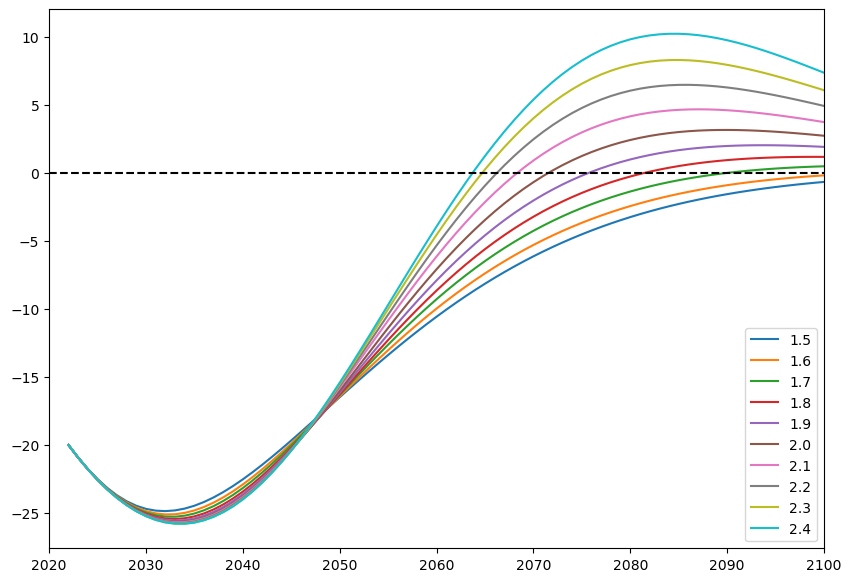

In [76]:
fig, ax = plt.subplots(figsize=(10, 7))
reg = 'NLD'
for T in xr_ecpc_alloc.Temperature:
    y, = plt.plot(xr_hist.Time, xr_hist.sel(Region=reg, Temperature=T) / emis_start.sel(Region=reg), label=float(T))
#     plt.plot(xr_all2.Time, xr_all2.sel(Region=reg) / xr_all2.sel(Region=reg, Time=2021), '.', c=y.get_color())
# plt.plot(xr_all2.Time, xr_all2.sel(Region=self.countries_iso).sum(dim='Region') / xr_all2.sel(Region=self.countries_iso).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
#plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
plt.plot([2020, 2100], [0, 0], 'k--')
plt.xlim([2020, 2100])
plt.legend()

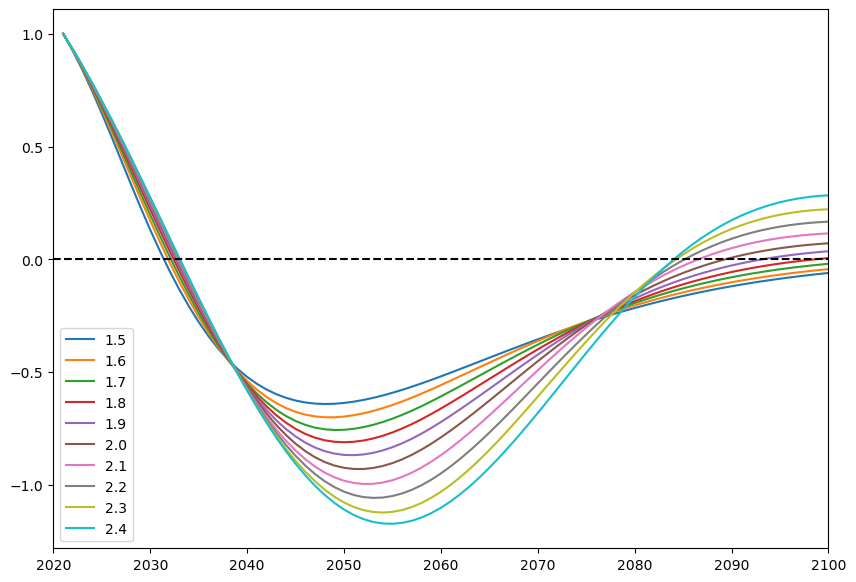

In [72]:
fig, ax = plt.subplots(figsize=(10, 7))
reg = 'NLD'
for T in xr_ecpc_alloc.Temperature:
    y, = plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T) / xr_ecpc_alloc.sel(Region=reg, Time=2021, Temperature=T), label=float(T))
#     plt.plot(xr_all2.Time, xr_all2.sel(Region=reg) / xr_all2.sel(Region=reg, Time=2021), '.', c=y.get_color())
# plt.plot(xr_all2.Time, xr_all2.sel(Region=self.countries_iso).sum(dim='Region') / xr_all2.sel(Region=self.countries_iso).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
#plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
plt.plot([2020, 2100], [0, 0], 'k--')
plt.xlim([2020, 2100])
plt.legend()

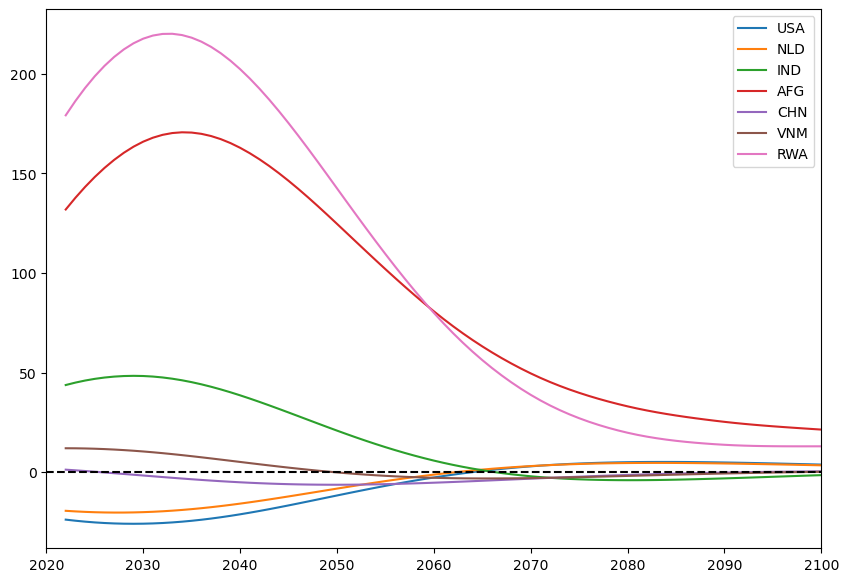

In [65]:
T = 2.0
fig, ax = plt.subplots(figsize=(10, 7))
for reg in ['USA', 'NLD', 'IND', 'AFG', 'CHN', 'VNM', 'RWA']:
    y, = plt.plot(xr_hist.Time, xr_hist.sel(Region=reg, Temperature=T) / emis_start.sel(Region=reg), label=reg)
#     plt.plot(xr_all2.Time, xr_all2.sel(Region=reg) / xr_all2.sel(Region=reg, Time=2021), '.', c=y.get_color())
# plt.plot(xr_all2.Time, xr_all2.sel(Region=self.countries_iso).sum(dim='Region') / xr_all2.sel(Region=self.countries_iso).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
#plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=1.6, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
plt.plot([2020, 2100], [0, 0], 'k--')
plt.xlim([2020, 2100])
plt.legend()

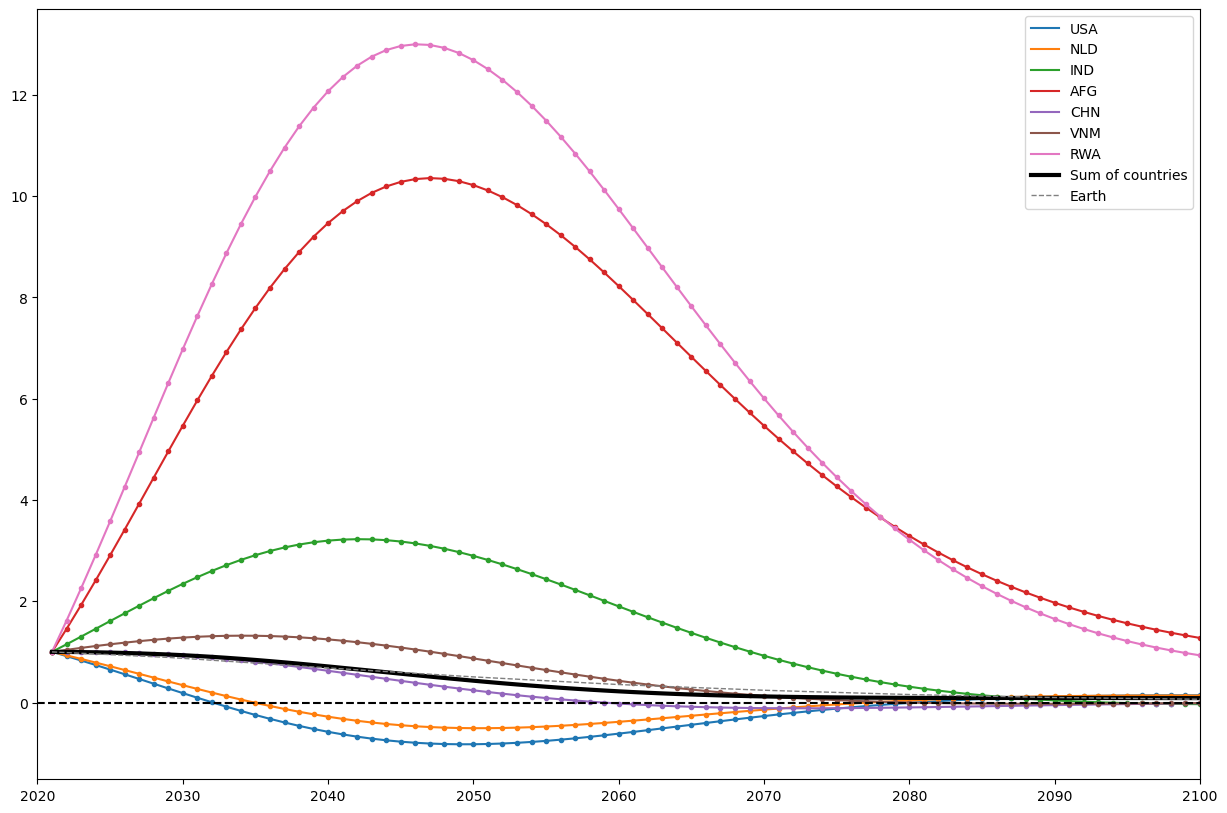

In [67]:
T = 2.0
fig, ax = plt.subplots(figsize=(15, 10))
for reg in ['USA', 'NLD', 'IND', 'AFG', 'CHN', 'VNM', 'RWA']:
    y, = plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T) / xr_ecpc_alloc.sel(Region=reg, Time=2021, Temperature=T), label=reg)
    plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=reg, Temperature=T) / xr_ecpc_alloc.sel(Region=reg, Temperature=T, Time=2021), '.', c=y.get_color())
plt.plot(xr_ecpc_alloc.Time, xr_ecpc_alloc.sel(Region=self.countries_iso, Temperature=T).sum(dim='Region') / xr_ecpc_alloc.sel(Region=self.countries_iso, Temperature=T).sum(dim='Region').sel(Time=2021), label='Sum of countries', lw=3, color='black')
plt.plot(self.xr_total.Time, self.xr_total.GHG_globe.sel(Temperature=T, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate') / self.xr_total.GHG_globe.sel(Time=2021, Temperature=T, Risk=0.5,NegEmis=0.5, NonCO2red=0.5, Timing='Immediate'), label='Earth', lw=1, color='grey', ls='--')
plt.plot([2020, 2100], [0, 0], 'k--')
plt.xlim([2020, 2100])
#plt.ylim([-2, 10])
plt.legend()

Requirements:
- At global net zero: fully compensated ECPC budget
- India: up and down, using baseline emissions somehow -> gamma function?
- No GF
- Think about negative budget represented
- Different NZ years?

### OLD

In [8]:
# Old
globalpath = self.emis_fut

emis_start_r = self.emis_hist.sel(Time=self.start_year_analysis,
                                            Region=self.focus_region)
emis_start_w = self.emis_hist.sel(Time=self.start_year_analysis,
                                            Region='EARTH')
emis_ratio = emis_start_r / emis_start_w
path_scaled_0 = emis_ratio * globalpath
budget_without_assumptions = path_scaled_0.sum(dim='Time')
budget_surplus = budget_left - budget_without_assumptions

def ecpc_factor(initial_path, f):
    '''
    Calculates a modified emissions path. Takes scaling factor f as input and
    returns a new emissions path by scaling the compensation form (xr_comp) with f
    and adding it to the initial emissions path (path_scaled_0).
    '''
    return initial_path + xr_comp * f

ecpc = ecpc_factor(path_scaled_0, budget_surplus)
ecpc_expanded = ecpc.expand_dims(Discount_factor=[discount],
                                    Historical_startyear=[startyear]).to_dataset(name='ECPC')

### Something with gamma function

In [52]:
from scipy.special import gamma

def gamma_distribution(t, a, b, E0):
    x = (t-2021)/10
    return (b**a / gamma(a) * x**(a - 1) * np.exp(-b * x))*E0

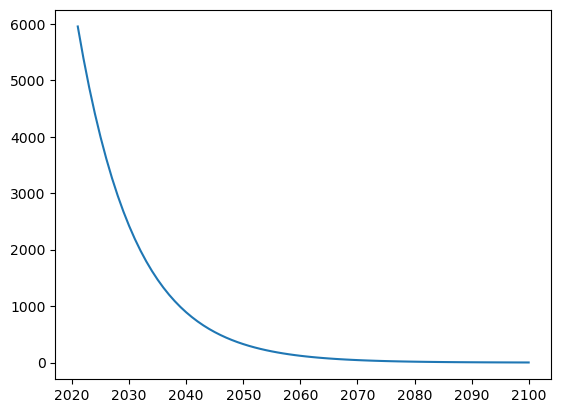

In [53]:
plt.plot(np.arange(2021, 2101, 1), gamma_distribution(np.arange(2021, 2101, 1), 1.0, 1, float(self.xr_total.GHG_hist.sel(Region=self.focus_region, Time=2021))))

### Something with iterative stuff

(2000.0, 2100.0)

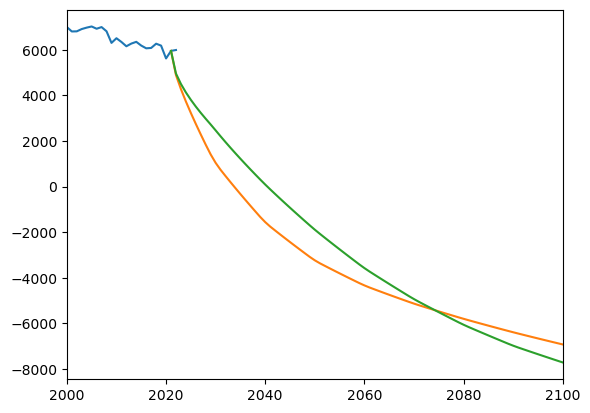

In [18]:
plt.plot(self.xr_total.Time, self.xr_total.GHG_hist.sel(Region=self.focus_region))
plt.plot(ecpc_expanded.Time, ecpc_expanded.ECPC.sel(Temperature=1.6, Risk=0.5, Discount_factor=0, Historical_startyear=1950, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2'))
plt.plot(ecpc_expanded.Time, ecpc_expanded.ECPC.sel(Temperature=2.0, Risk=0.5, Discount_factor=0, Historical_startyear=1950, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2'))
plt.xlim([2000, 2100])

In [ ]:
# make sqrt curve
compensation_form_sqrt = np.sqrt(np.arange(0, 2101 - self.start_year_analysis))
# sum of values has to be 1
compensation_form_sqrt = compensation_form_sqrt / np.sum(compensation_form_sqrt)

xr_comp = xr.DataArray(compensation_form_sqrt, dims=['Time'], coords={'Time': self.analysis_timeframe})

# Defining the timeframes for historical and future emissions
xrs = []
hist_emissions_startyears = self.settings['params']['hist_emissions_startyears']
discount_rates = self.settings['params']['discount_rates']

for startyear in hist_emissions_startyears:
    hist_emissions_timeframe = np.arange(startyear, 1 + self.start_year_analysis)
    future_emissions_timeframe = np.arange(self.start_year_analysis + 1, 2101)

    # Summing all historical CO2 emissions over the hist_emissions_timeframe
    hist_emissions = self.emis_hist.sel(Time = hist_emissions_timeframe)

    # Discounting -> We only do past discounting here
    for discount in discount_rates:
        past_timeline = np.arange(startyear, self.start_year_analysis + 1)

        discount_factor = (1 - discount / 100)
        discount_period = self.start_year_analysis - past_timeline
        xr_discount = xr.DataArray(discount_factor ** discount_period, dims=['Time'],
                                coords={'Time': past_timeline})
        hist_emissions_discounted = (hist_emissions * xr_discount).sum(dim='Time')
        hist_emissions_w = float(hist_emissions_discounted.sel(Region='EARTH'))
        hist_emissions_r = float(hist_emissions_discounted.sel(Region = self.focus_region))

        # Summing all future emissions over the future_emissions_timeframe
        future_emissions_w = self.emis_fut.sel(Time = future_emissions_timeframe).sum(dim='Time')

        total_emissions_w = hist_emissions_w + future_emissions_w

        # Calculating the cumulative population shares for region and world
        cum_pop = self.xr_total.Population.sel(Time = self.analysis_timeframe).sum(dim='Time')
        cum_pop_r = cum_pop.sel(Region=self.focus_region)
        cum_pop_w = cum_pop.sel(Region='EARTH')
        share_cum_pop = cum_pop_r / cum_pop_w
        budget_rightful = total_emissions_w * share_cum_pop
        budget_left = budget_rightful - hist_emissions_r

        # Now temporal allocation
        #globalbudget = self.xr_total.CO2_globe.sel(Time=self.analysis_timeframe).sum(dim='Time')
        globalpath = self.emis_fut

        emis_start_r = self.emis_hist.sel(Time=self.start_year_analysis,
                                                    Region=self.focus_region)
        emis_start_w = self.emis_hist.sel(Time=self.start_year_analysis,
                                                    Region='EARTH')
        emis_ratio = emis_start_r / emis_start_w
        path_scaled_0 = emis_ratio * globalpath
        budget_without_assumptions = path_scaled_0.sum(dim='Time')
        budget_surplus = budget_left - budget_without_assumptions

        def ecpc_factor(initial_path, f):
            '''
            Calculates a modified emissions path. Takes scaling factor f as input and
            returns a new emissions path by scaling the compensation form (xr_comp) with f
            and adding it to the initial emissions path (path_scaled_0).
            '''
            return initial_path + xr_comp * f

        ecpc = ecpc_factor(path_scaled_0, budget_surplus)
        ecpc_expanded = ecpc.expand_dims(Discount_factor=[discount],
                                            Historical_startyear=[startyear]).to_dataset(name='ECPC')
        xrs.append(ecpc_expanded)

xr_ecpc = xr.merge(xrs)
self.xr_total = self.xr_total.assign(ECPC = xr_ecpc.ECPC)

Allocations specifically for Norway and Netherlands if you want to harmonize to national data

In [4]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

for lulucf in ['incl', 'excl']:
    for gas in ['GHG', 'CO2']:
        for dataread_file in ['xr_dataread.nc', 'xr_dataread_nor.nc']: # This is only necessary if for a country a specific historical emissions profile is required beyond what is in Jones (e.g. Norway was requested)
            allocator = allocation('NOR', lulucf=lulucf, gas=gas, dataread_file=dataread_file)
            allocator.gf()
            allocator.pc()
            allocator.pcc()
            allocator.pcb()
            allocator.ecpc()
            allocator.ap()
            allocator.gdr()
            allocator.save()
            print('NOR', lulucf, gas, dataread_file, 'done')

NOR incl GHG xr_dataread.nc done
NOR incl GHG xr_dataread_nor.nc done
NOR incl CO2 xr_dataread.nc done
NOR incl CO2 xr_dataread_nor.nc done
NOR excl GHG xr_dataread.nc done
NOR excl GHG xr_dataread_nor.nc done
NOR excl CO2 xr_dataread.nc done
NOR excl CO2 xr_dataread_nor.nc done


Allocation class

In [14]:
import class_allocation
reload(class_allocation)
from class_allocation import allocation

regions_iso = np.load("K:/Data/Data_effortsharing/DataUpdate_ongoing/all_regions.npy", allow_pickle=True)
for cty in tqdm(regions_iso):
    allocator = allocation(cty, lulucf='incl', gas='GHG')
    allocator.gf()
    allocator.pc()
    allocator.pcc()
    allocator.pcb()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    allocator.save()

100%|██████████| 207/207 [1:59:49<00:00, 34.73s/it]  


Allocation rules combining approaches (Robiou paper)

In [7]:
import class_allocation_combinedapproaches
reload(class_allocation_combinedapproaches)
from class_allocation_combinedapproaches import allocation_comb

allocator = allocation_comb(lulucf='excl', gas='GHG')
allocator.ecpc()
allocator.discounting_historical_emissions()
allocator.approach1gdp()
allocator.approach1hdi()
allocator.approach2()
allocator.approach2_transition()
allocator.combine()
allocator.get_relation_2030emis_temp()
allocator.determine_tempoutcomes()
allocator.save()

Temperature NDC-alignment metric

In [3]:
import class_tempalign
reload(class_tempalign)
from class_tempalign import tempaligning

tempaligner = tempaligning() # FIRST RUN AGGREGATOR FOR THIS!! (2030 alloc)
tempaligner.get_relation_2030emis_temp()
tempaligner.determine_tempoutcomes()
tempaligner.save()

# ==================================== #
# Initializing tempaligning class        #
# ==================================== #
- Determine relation between 2030-emissions and temperature outcome
- Determine temperature metric


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


- Save


Reading policy scenarios from ENGAGE

In [3]:
import class_policyscens
reload(class_policyscens)
from class_policyscens import policyscenadding

policyscenner = policyscenadding()
policyscenner.read_engage_data()
policyscenner.filter_and_convert()
policyscenner.add_to_xr()

# ==================================== #
# Initializing policyscenadding class  #
# ==================================== #
- Read ENGAGE scenarios and change region namings
- Filter correct scenarios and convert to xarray object
- Add to overall xrobject


Variance decomposition

In [7]:
import class_variancedecomp
reload(class_variancedecomp)
from class_variancedecomp import vardecomposing

vardecomposer = vardecomposing(startyear=2021, gas='GHG', lulucf='incl')
vardecomposer.sobolindices = {}
print('- Starting sobols for fixed years, over many countries')
timeseries = np.arange(2030, 2101, 5)
for year in timeseries:
    print('  Starting with', year)
    xr_cty, ar_time, array_dims, array_inputs, problem, samples = vardecomposer.prepare_global_sobol(year)
    vardecomposer.sobolindices[year] = vardecomposer.apply_decomposition(xr_cty, ar_time, array_dims, array_inputs, problem, samples)
vardecomposer.save(array_dims, timeseries)

# ==================================== #
# Initializing vardecomposing class    #
# ==================================== #
- Starting sobols for fixed years, over many countries
  Starting with 2030


207it [02:30,  1.38it/s]


  Starting with 2035


207it [02:19,  1.49it/s]


  Starting with 2040


207it [02:16,  1.52it/s]


  Starting with 2045


207it [02:12,  1.57it/s]


  Starting with 2050


207it [02:12,  1.56it/s]


  Starting with 2055


207it [02:14,  1.54it/s]


  Starting with 2060


207it [02:12,  1.56it/s]


  Starting with 2065


207it [02:10,  1.59it/s]


  Starting with 2070


207it [02:10,  1.59it/s]


  Starting with 2075


207it [02:09,  1.60it/s]


  Starting with 2080


207it [02:10,  1.59it/s]


  Starting with 2085


207it [02:14,  1.54it/s]


  Starting with 2090


207it [02:09,  1.60it/s]


  Starting with 2095


207it [02:09,  1.60it/s]


  Starting with 2100


207it [02:12,  1.56it/s]

- Save global results
